In [1]:
%matplotlib inline
import os

import ipywidgets as ipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from scipy.stats import zscore
from skimage import io
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_val_predict, KFold, LeaveOneOut, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import minmax_scale
from sklearn.svm import SVC

## 1. read single image, and display it

#### read image

In [2]:
single_img = io.imread('/home/kamil/Desktop/epfl/data/timepoint_12.tiff')

#### check data type and shape

In [3]:
print(type(single_img))
print(single_img.shape)

<class 'numpy.ndarray'>
(40, 256, 180)


#### plot single image interactively (it is an image stack that has 40 layers)

In [4]:
@ipy.interact(layer=ipy.widgets.IntSlider(value=26, min=0, max=39))
def f(layer):
    fig, ax = plt.subplots(figsize=(4, 8)) # here you can change figure size
    ax.matshow(single_img[layer,:,:], cmap='hot')

# in case you want to play with colormaps:
# https://matplotlib.org/examples/color/colormaps_reference.html

interactive(children=(IntSlider(value=26, description='layer', max=39), Output()), _dom_classes=('widget-interact',))

#### in case you had troubles with the previous widget, you can simply use following cell (not interactive)

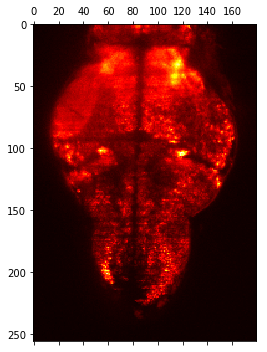

In [5]:
fig, ax = plt.subplots(figsize=(4, 8)) # here you can change figure size
ax.matshow(single_img[28,:,:], cmap='hot') # integer number is layer index (here 28)

# Load dataset

We will need data in two different forms
1. `images_dict`. It it dictionary (Python data structure)
2. `images_matrix`. 2-dimensional numpy array

Simply run the following cell to prepare data

In [6]:
path_template = '/home/kamil/Desktop/epfl/data/'
images_dict = dict()
images_matrix = np.zeros([100, 40*256*180])
i = 0
for img_name in sorted(os.listdir(path_template)):
    img = io.imread(os.path.join(path_template, img_name))
    images_dict[img_name[:-5]] = img
    images_matrix[i] = np.reshape(img, [-1], order='C')
    i = i+1

print(images_matrix.shape)

(100, 1843200)


# Work towards PCA analysis

In order to perform PCA analysis, images need to be preprocessed in the certain way. This part of the notebook will guide you through this process.

## 2. subtract background

#### interactive widget
Here you can interactively explore which threshold value is most appropriate.
1. threshold slider -> to pick different values of the threshold
2. img_layer slider -> to browse different layer in the images stack

In [7]:
@ipy.interact(threshold=ipy.widgets.IntSlider(value=90, min=90, max=170))
def f(threshold):
    timepoint = np.copy(images_dict['timepoint_12'])
    timepoint[timepoint <= threshold] = 0

    @ipy.interact(img_layer=ipy.widgets.IntSlider(value=26, min=0, max=39))
    def f(img_layer):
        fig, ax = plt.subplots(figsize=(5,10))
        ax.matshow(timepoint[img_layer,:,:], cmap='hot')

interactive(children=(IntSlider(value=90, description='threshold', max=170, min=90), Output()), _dom_classes=('widget-interact',))

#### non-interactive version

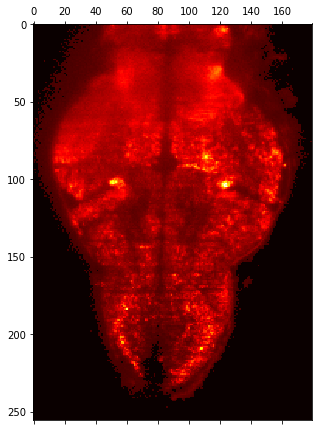

In [8]:
threshold = 120 # manipulate this
timepoint = np.copy(images_dict['timepoint_12'])
timepoint[timepoint <= threshold] = 0
fig, ax = plt.subplots(figsize=(5,10))
ax.matshow(timepoint[26,:,:], cmap='hot')

### 2.1 compare before-after

In [9]:
@ipy.interact(img_layer=ipy.widgets.IntSlider(value=26, min=0, max=39))
def f(img_layer):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    ax1.matshow(images_dict['timepoint_12'][img_layer,:,:], cmap='hot')
    ax1.set_title('before', size='26')
    ax2.matshow(timepoint[img_layer,:,:], cmap='hot')
    ax2.set_title('after', size='26')

interactive(children=(IntSlider(value=26, description='img_layer', max=39), Output()), _dom_classes=('widget-interact',))

Text(0.5,1.05,'after')

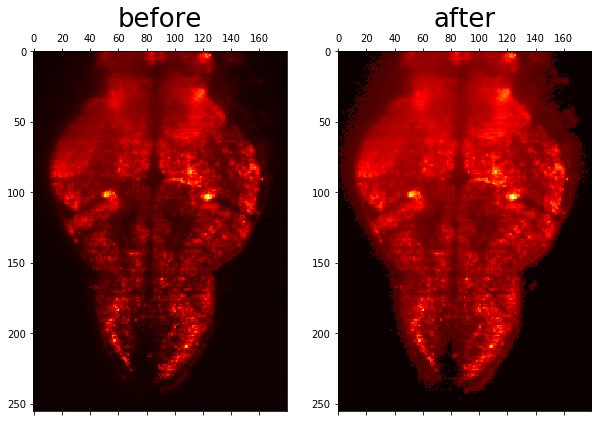

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
ax1.matshow(images_dict['timepoint_12'][26,:,:], cmap='hot')
ax1.set_title('before', size='26')

ax2.matshow(timepoint[26,:,:], cmap='hot')
ax2.set_title('after', size='26')

## 3. remove pixels with zeros

### 3.1 get indices with nonzero pixels

Procedure is as follows:
1. vectorize image stack `timepoint`.
2. get only nonzero positions in the vector

As a result the `inx` stores indices of nonzero values.

In [11]:
timepoint_vector = np.reshape(timepoint, [-1], order='C')
timepoint_vector.shape

inx = np.nonzero(timepoint_vector)
print(inx[0])
print(len(inx[0]))

[      2       4       5 ... 1826015 1826169 1826172]
1182960


### 3.2 get only foreground pixels

In [12]:
images_matrix_fg = np.zeros([100, len(inx[0])]) # fg = foreground
for i in range(images_matrix.shape[0]):
    images_matrix_fg[i,:] = images_matrix[i,inx[0]]

print('images matrix has shape:            {}'.format(images_matrix.shape))
print('images matrix foreground has shape: {}'.format(images_matrix_fg.shape))

images matrix has shape:            (100, 1843200)
images matrix foreground has shape: (100, 1182960)


## 4. normalize input

In [13]:
images_matrix_fg_norm = zscore(images_matrix_fg, axis=1)
images_matrix_fg_norm = np.nan_to_num(images_matrix_fg_norm)

#im2d_n = zscore(im2d_fg, axis=0) # im2d_n = image 2d normalized (double check the axis (0,1,None))
#im2d_n = np.nan_to_num(im2d_n)

### 4.1 check normalization

In [14]:
print('max value:   {}'.format(images_matrix_fg_norm.max()))
print('min value:   {}'.format(images_matrix_fg_norm.min()))
print('mean values: {}'.format(images_matrix_fg_norm.mean(axis=1)))
print('std values:  {}'.format(images_matrix_fg_norm.std(axis=1)))
#im2d_n.std(axis=0)

max value:   38.0226951559131
min value:   -1.4905606981829793
mean values: [ 1.24646504e-16 -8.45712595e-17  9.59114966e-17 -1.40503615e-16
 -3.52700594e-17  1.36467260e-16 -2.91194223e-17  3.72401853e-17
  1.27625719e-16 -6.14102669e-17  6.86180447e-17 -3.70960298e-17
  5.66050817e-17 -1.09846534e-16 -1.14363408e-17  6.91946669e-17
 -3.62310964e-17 -7.53453040e-17 -4.08440742e-17  1.75869778e-17
  1.09942637e-16 -2.99843557e-17  4.37271853e-17  7.01557039e-17
 -5.62206669e-17 -1.39158163e-16  1.38773749e-16 -2.31609927e-17
  1.73274978e-16 -5.15596372e-17 -2.46986519e-17  8.89920299e-17
 -1.93168445e-17 -1.13786786e-16 -9.01452744e-17  4.61297779e-18
  1.41272445e-16  1.09558223e-17  4.22856298e-17  1.64337334e-17
 -1.19168593e-17 -4.68025039e-17 -1.33103630e-16  5.29531409e-17
  1.76350297e-17 -1.42617897e-16 -7.24621928e-17 -1.17246519e-16
 -3.36362964e-18 -5.45869039e-17  4.18291372e-17 -5.18960002e-18
 -8.95686522e-17 -7.24621928e-17  4.20934224e-17 -1.02350445e-16
  1.33680252e-

## 5. clip outliers

In [15]:
images_matrix_fg_norm_clipped = np.clip(images_matrix_fg_norm, a_min=-3.0, a_max=3.0)
print('min: {}'.format(images_matrix_fg_norm_clipped.min()))
print('max: {}'.format(images_matrix_fg_norm_clipped.max()))

min: -1.4905606981829793
max: 3.0


## 6. calculate PCA

In [16]:
n_components = 50
pca = PCA(n_components=n_components)
pca_space = pca.fit_transform(images_matrix_fg_norm_clipped)

### 6.1 check output

In [17]:
print('output data type: ' + str(type(pca_space)))
print('output shape:     ' + str(pca_space.shape))

output data type: <class 'numpy.ndarray'>
output shape:     (100, 50)


#### 6.1 prepare principal components for visualization
Reshape back to the original size (256, 180, 40)

In [18]:
pca_space_bg = np.zeros([40*256*180, n_components]) # pca_space_bg = PCA space with background (zeros)
for i in range(pca_space_bg.shape[1]):
    pca_space_bg[inx, i]= pca.components_[i,:] # Note that here we make use of the previously computed inx
pca_space_bg = pca_space_bg.reshape([40, 256, 180, -1])
print(pca_space_bg.shape)

(40, 256, 180, 50)


## 7. visualize principal components

#### interactive widget

In [19]:
@ipy.interact(principal_component=ipy.widgets.IntSlider(value=0, min=0, max=59))
def f(principal_component):
    @ipy.interact(img_layer=ipy.widgets.IntSlider(value=26, min=0, max=39))
    def f(img_layer):
        fig, ax = plt.subplots(figsize=(7,7))
        cax = ax.matshow(pca_space_bg[img_layer,:,:, principal_component], cmap='PiYG')
        fig.colorbar(cax)

interactive(children=(IntSlider(value=0, description='principal_component', max=59), Output()), _dom_classes=('widget-interact',))

#### Interactive wigdet: display only max projections (easier to visually inspect)

In [20]:
pca_abs = np.abs(pca_space_bg)
@ipy.interact(principal_component=ipy.widgets.IntSlider(value=0, min=0, max=59))
def f(principal_component):
    fig, ax = plt.subplots(figsize=(7,7))
    ax.matshow(pca_abs.max(axis=0)[:,:,principal_component], cmap='hot')

interactive(children=(IntSlider(value=0, description='principal_component', max=59), Output()), _dom_classes=('widget-interact',))

#### non-interactive: display only max projections (easier to visually inspect)

In [21]:
pca_abs = np.abs(pca_space_bg)

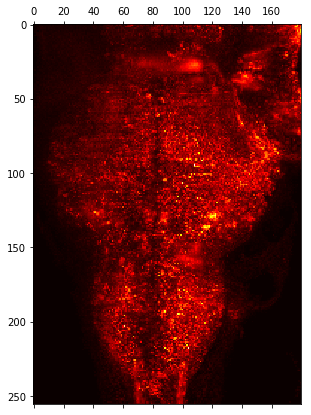

In [22]:
fig, ax = plt.subplots(figsize=(7,7))
ax.matshow(pca_abs.max(axis=0)[:,:,0], cmap='hot') # change int here

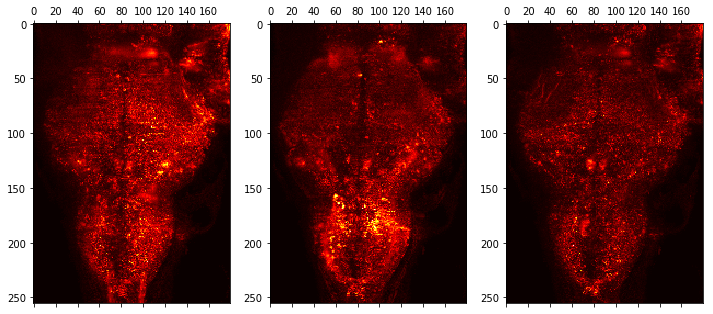

In [23]:
# three plot on one figure
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
ax1.matshow(pca_abs.max(axis=0)[:,:,0], cmap='hot') # change int here (range = 0, n_components)
ax2.matshow(pca_abs.max(axis=0)[:,:,1], cmap='hot') # change int here (range = 0, n_components)
ax3.matshow(pca_abs.max(axis=0)[:,:,2], cmap='hot') # change int here (range = 0, n_components)

## 12. visualize variance explained ratio

Text(0.5,0,'number of components')

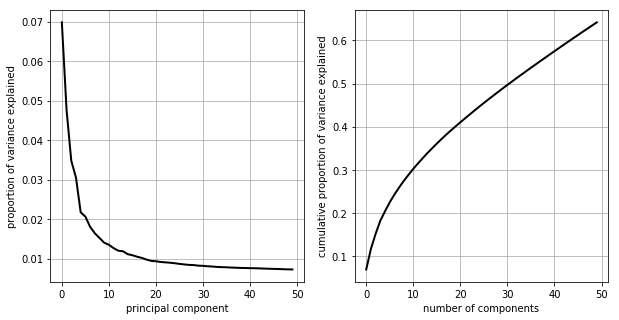

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5), facecolor='w')
ax1.plot(pca.explained_variance_ratio_, color='black', lw=2)
ax1.grid(axis='both')
ax1.set_ylabel('proportion of variance explained', fontsize=10)
ax1.set_xlabel('principal component', fontsize=10)

ax2.plot(np.cumsum(pca.explained_variance_ratio_), color='black', lw=2)
ax2.grid(axis='both')
ax2.set_ylabel('cumulative proportion of variance explained', fontsize=10)
ax2.set_xlabel('number of components', fontsize=10)

### end of the PCA analysis

If this task was easy for you, you may want to try different dimensionality reduction methods. Sklearn offers coherent API for many methods.
Please refer to sklearn.decomposition module: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition.

# calculate t-SNE embeddings on the PCA space

In [25]:
from sklearn.manifold import TSNE

### prepare PCA space

In [26]:
n_components = 99
pca = PCA(n_components=n_components)
pca_space = pca.fit_transform(images_matrix_fg_norm_clipped)
print('pca space dimensions: {}'.format(pca_space.shape))

pca space dimensions: (100, 99)


### explore t-SNE embeddings as a function of the perplexity

In [27]:
@ipy.interact(perplexity=ipy.widgets.IntSlider(value=29, min=0, max=50))
def f(perplexity):
    @ipy.interact(n_iter=ipy.widgets.IntSlider(value=1000, min=500, max=5000))
    def g(n_iter):
        tsne = TSNE(n_components=2, n_iter=n_iter, perplexity=perplexity)
        tsne_output = tsne.fit_transform(pca_space)
        print('t-SNE output has shape: {}'.format(tsne_output.shape))
        fig, ax = plt.subplots(figsize=(7,7))
        ax.scatter(tsne_output[:,0], tsne_output[:,1])
        ax.grid(axis='both')

interactive(children=(IntSlider(value=29, description='perplexity', max=50), Output()), _dom_classes=('widget-interact',))

#### non-interactive version

t-SNE output has shape: (100, 2)


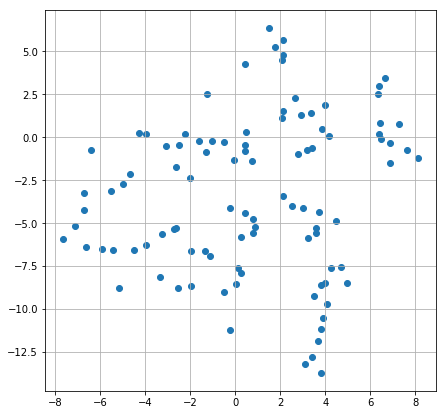

In [28]:
perplexity=29 # manipulate this
n_iter=1000
tsne = TSNE(n_components=2, n_iter=n_iter,  perplexity=perplexity)
tsne_output = tsne.fit_transform(pca_space)
print('t-SNE output has shape: {}'.format(tsne_output.shape))
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(tsne_output[:,0], tsne_output[:,1])
ax.grid(axis='both')

# cluster t-SNE embeddings using DBSCAN

In [29]:
from sklearn.cluster import DBSCAN

### explore clustering results as a function of two parameters: eps and nim_samples

In [30]:
tsne = TSNE(n_components=2, n_iter=1000,  perplexity=29)
tsne_output = tsne.fit_transform(pca_space)
@ipy.interact(eps=ipy.widgets.FloatSlider(value=1.2, min=0, max=10))
def f(eps):
    @ipy.interact(min_samples=ipy.widgets.IntSlider(value=5, min=3, max=50))
    def g(min_samples):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_output = dbscan.fit_predict(tsne_output)
        plt.scatter(x=tsne_output[:,0], y=tsne_output[:,1], c=dbscan_output)
        plt.grid()
        print(dbscan_output)

interactive(children=(FloatSlider(value=1.2, description='eps', max=10.0), Output()), _dom_classes=('widget-interact',))

#### non-interactive version

[ 0  0  0  0  0  0  0  0 -1 -1  0  1  1  1  1  1  1  2  2  2  2  2  2  2
  2  2  2  2  2 -1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  3 -1  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  5 -1 -1  5  5  5  5  5  5  5  5  5  5  5  5  5  5 -1  5  5  5  5  5
  5  5  5  5]


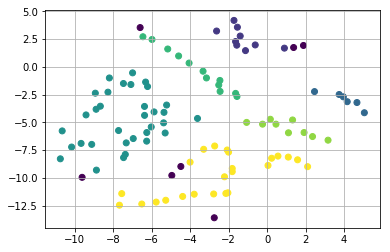

In [44]:
eps=1.9 # manipulate this
min_samples=5 # manipulate this

tsne = TSNE(n_components=2, n_iter=1000,  perplexity=29)
tsne_output = tsne.fit_transform(pca_space)

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_output = dbscan.fit_predict(tsne_output)
plt.scatter(x=tsne_output[:,0], y=tsne_output[:,1], c=dbscan_output)
plt.grid()
print(dbscan_output)

# Developmental state classification
Early vs. late development of the zebrafish
labeling scheme:
* early = 0
* late  = 1

In [32]:
n_components = 15
pca = PCA(n_components=n_components)
pca_space_late = pca.fit_transform(images_matrix_fg_norm_clipped)
print('pca space dimensions: {}'.format(pca_space.shape))

pca space dimensions: (100, 99)


In [33]:
pca_space_early = np.load('/home/kamil/Desktop/pca_space_early.npy', allow_pickle=False)
print(type(pca_space_early))
print(pca_space_early.shape)

<class 'numpy.ndarray'>
(100, 99)


#### prepare input data

In [34]:
y = np.concatenate((np.zeros([100]).astype(np.int), np.ones([100]).astype(np.int)), axis=0)
X = np.concatenate((pca_space_early[:,0:5], pca_space_late[:,0:5]), axis=0)

print(X.shape)
print(y.shape)

(200, 5)
(200,)


### prepare experiment with SVC

#### linear kernel

In [35]:
C = 3 # manipulate this
cv_scheme = KFold(n_splits=10, shuffle=True, random_state=120715)
model = SVC(C=C, kernel='linear')
y_pred = cross_val_predict(model, X, y, cv=cv_scheme, n_jobs=1, verbose=0, method='predict')
print(accuracy_score(y, y_pred))

0.4


#### `rbf` kernel

In [36]:
C = 3 # manipulate this
cv_scheme = KFold(n_splits=10, shuffle=True, random_state=120715)
model = SVC(C=3, kernel='rbf')
y_pred = cross_val_predict(model, X, y, cv=cv_scheme, n_jobs=1, verbose=0, method='predict')
print(accuracy_score(y, y_pred))

0.745


### visualize timepoints with highest probability

In [37]:
timepoint_early = np.load('/home/kamil/Desktop/timepoint_68_early.npy', allow_pickle=False)
timepoint_late = np.load('/home/kamil/Desktop/timepoint_63_late.npy', allow_pickle=False)
print(type(timepoint_early))
print(type(timepoint_late))
print(timepoint_early.shape)
print(timepoint_late.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(256, 180)
(256, 180)


Text(0.5,1.05,'late')

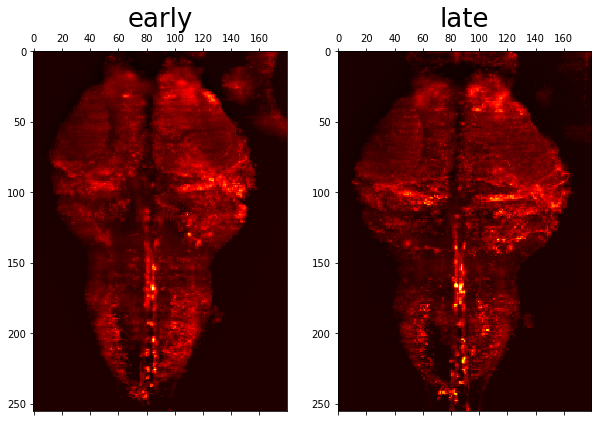

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
ax1.matshow(timepoint_early, cmap='hot')
ax1.set_title('early', size='26')
ax2.matshow(timepoint_late, cmap='hot')
ax2.set_title('late', size='26')

#### run grid search

In [39]:

model = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C': [0.01,1,3,7]}
scoring=make_scorer(accuracy_score)
cv_scheme = KFold(n_splits=10, shuffle=True, random_state=120715)
gs = GridSearchCV(model, parameters, scoring=scoring, cv=cv_scheme)
gs.fit(X,y)
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df

/home/kamil/Documents/envs/epfl/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/kamil/Documents/envs/epfl/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/kamil/Documents/envs/epfl/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_kernel,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.004083,0.000417,0.390,0.537778,0.01,linear,"{'C': 0.01, 'kernel': 'linear'}",7,0.45,0.561111,...,0.25,0.561111,0.30,0.533333,0.50,0.611111,0.001556,0.000098,0.076811,0.048927
1,0.001776,0.000369,0.455,0.607778,0.01,rbf,"{'C': 0.01, 'kernel': 'rbf'}",4,0.45,0.505556,...,0.35,0.516667,0.40,0.511111,0.45,0.505556,0.000053,0.000034,0.093408,0.196154
2,0.230493,0.000358,0.390,0.537778,1,linear,"{'C': 1, 'kernel': 'linear'}",7,0.45,0.561111,...,0.25,0.561111,0.30,0.538889,0.50,0.611111,0.157602,0.000025,0.080000,0.049241
3,0.002100,0.000362,0.730,1.000000,1,rbf,"{'C': 1, 'kernel': 'rbf'}",3,0.70,1.000000,...,0.90,1.000000,0.75,1.000000,0.80,1.000000,0.000060,0.000018,0.081240,0.000000
4,0.788216,0.000366,0.400,0.536667,3,linear,"{'C': 3, 'kernel': 'linear'}",5,0.45,0.561111,...,0.25,0.561111,0.30,0.538889,0.50,0.611111,1.099829,0.000016,0.080623,0.050320
5,0.002114,0.000359,0.745,1.000000,3,rbf,"{'C': 3, 'kernel': 'rbf'}",1,0.70,1.000000,...,0.90,1.000000,0.75,1.000000,0.80,1.000000,0.000039,0.000015,0.085000,0.000000
6,1.252856,0.000408,0.395,0.536111,7,linear,"{'C': 7, 'kernel': 'linear'}",6,0.45,0.561111,...,0.25,0.561111,0.30,0.544444,0.50,0.611111,0.937833,0.000023,0.085000,0.052071
7,0.002369,0.000449,0.745,1.000000,7,rbf,"{'C': 7, 'kernel': 'rbf'}",1,0.70,1.000000,...,0.90,1.000000,0.75,1.000000,0.80,1.000000,0.000104,0.000115,0.085000,0.000000


### prepare experiment with Gaussian Naive Bayes

In [40]:
cv_scheme = KFold(n_splits=10, shuffle=True, random_state=120715)
model = GaussianNB()
y_pred = cross_val_predict(model, X, y, cv=cv_scheme, n_jobs=1, verbose=0, method='predict')
print(accuracy_score(y, y_pred))

0.71


# Final remarks

Final chart with some insights on one visualization

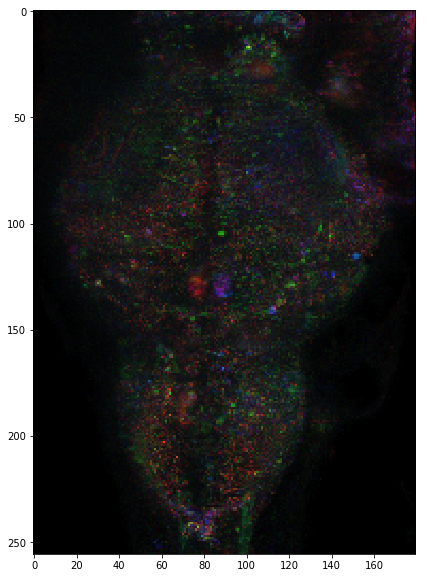

In [41]:
final_chart = pca_abs.max(axis=0)[:,:,[2,9,12]]
final_chart = final_chart / final_chart.max()
final_chart = final_chart*255
img = Image.fromarray(final_chart.astype(np.uint8))

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img)

# end